# 代码说明：加载自己训练的模型进行推理预测，展示预测结果

## 导入库

In [1]:
# 导入自己的模型文件
from MyDeepLab import *
from torchvision import transforms
from data import custom_transform as tr

## 加载模型参数

In [2]:
#state_dict = torch.load('run/laneline/deeplab-mobilenet/model_best.pth.tar', map_location=torch.device('cpu'))
state_dict = torch.load('run/laneline/deeplab-mobilenet/experiment_10/checkpoint.pth.tar')

## 创建模型对象，加载参数

In [3]:
my_model = MyDeepLab(backbone='mobilenet', output_stride=16, num_classes=8)
my_model.load_state_dict(state_dict['state_dict'])
my_model.eval()

MyDeepLab(
  (backbone): MyMobileNetV2(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace)
          (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

## 接口定义

In [4]:
def get_palette(num_cls):
    """ Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """
    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
            palette[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
            palette[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
            i += 1
            lab >>= 3
    return palette

def preprocess(img):
    """
    输入图像预处理
    """
    # Normalize
    img = np.array(img).astype(np.float32)
    img /= 255.0
    img -= (0.485, 0.456, 0.406)
    img /= (0.229, 0.224, 0.225)
    img = np.transpose(img, (2,0,1))
    img = np.expand_dims(img, axis=0)
    img = torch.from_numpy(img).float()
    return img

def preprocess_2(img):
    composed_transforms = transforms.Compose([
            #tr.RandomHorizontalFlip(),
            #tr.RandomScaleCrop(base_size=self.args.base_size, crop_size=self.args.crop_size), # 原始实现
            tr.RandomCrop(crop_size=513),     # 自己优化
            #tr.RandomGaussianBlur(),
            tr.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            tr.ToTensor()])

    target = img.convert('L')
    sample = {'image': img, 'label': target}

    return composed_transforms(sample)

def postprocess(output):
    """
    后处理：将输出结果转换为类别分割图
    """
    output = output.numpy()
    output = output[0]
    output = np.asarray(np.argmax(output, axis=0), dtype=np.uint8)
    return output

## 读取读片，推理预测，结果展示

### week_4结果

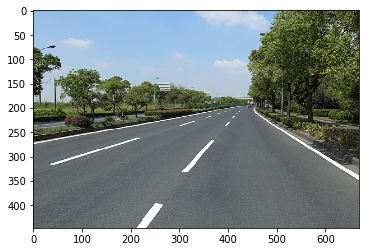

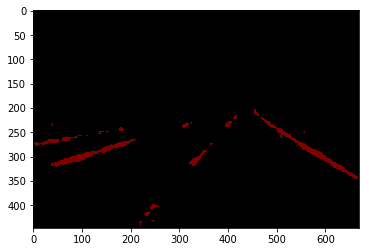

In [8]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = Image.open('test2.jpg').convert('RGB')
plt.figure()
plt.imshow(img)
plt.figure()

my_model.eval()
with torch.no_grad():
    input = preprocess(img)
    output = my_model(input)
    output = postprocess(output)
    mask_img = Image.fromarray(output)
    mask_img.putpalette(get_palette(21))
    plt.imshow(mask_img)

### week_5结果

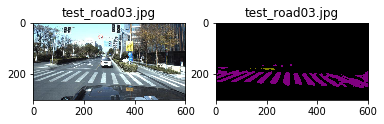

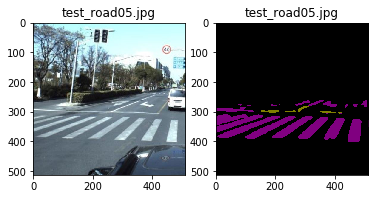

In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img_list = ['test_road03.jpg','test_road05.jpg']
# img = Image.open('test4.jpg').convert('RGB')
# w, h = img.size
# print(w, h)
# s = 1
# ow = int(w * s)
# oh = int(h * s)
# print(ow, oh)
# img = img.resize((ow, oh), Image.BILINEAR)
# plt.figure()
# plt.imshow(img)
# plt.figure()

my_model.eval()
with torch.no_grad():
    for img_name in img_list:
        import pdb
        #pdb.set_trace()
        img = Image.open(img_name).convert('RGB')
        input = preprocess(img)
        #input = preprocess_2(img)
        #print(input['image'].shape)
        #output = my_model(input['image'].view(1,3,513,513))
        output = my_model(input)
        output = postprocess(output)
        mask_img = Image.fromarray(output)
        mask_img.putpalette(get_palette(8))
        #plt.imshow(mask_img)
        plt.figure()
        plt.subplot(121),plt.imshow(img),plt.title(img_name)
        plt.subplot(122),plt.imshow(mask_img),plt.title(img_name)